In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import numpy as np
import pandas as pd
from numpy import genfromtxt
from sklearn.datasets import load_boston
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
import h5py

In [2]:
dta = pd.read_csv("cattle_corn_soybean_weather.csv",index_col = 0)
dta['Cattle'] = dta['Cattle production in lb'].apply(lambda x: float(x.replace(",","")))
dta['Corn'] = dta['Corn production in tons'].apply(lambda x: float(x.replace(",","")) if type(x) == str else x)
dta['Soybean'] = dta['Soybeans production in bu'].apply(lambda x: x)
dta.drop(['Cattle production in lb','Corn production in tons','Soybeans production in bu'],axis=1,inplace=True)
x = dta.dropna()[['STATE', 'TAVG', 'EMXT', 'EMNT', 'DX90', 'DT32',
       'PRCP', 'SNOW', 'AWND', 'Corn', 'Soybean']]
y = dta.dropna()['Cattle']

In [3]:
labelencoder = LabelEncoder()
x['STATE'] = labelencoder.fit_transform(x['STATE'])


In [4]:
cattle_features = x.values
cattle_labels = np.array(y)

In [5]:
def read_dataset(filePath,delimiter=','):
    return genfromtxt(filePath, delimiter=delimiter)

def read_boston_data():
    boston = load_boston()
    features = np.array(boston.data)
    labels = np.array(boston.target)
    return features, labels

def feature_normalize(dataset):
    mu = np.mean(dataset,axis=0)
    sigma = np.std(dataset,axis=0)
    return (dataset - mu)/sigma

def append_bias_reshape(features,labels):
    n_training_samples = features.shape[0]
    n_dim = features.shape[1]
    f = np.reshape(np.c_[np.ones(n_training_samples),features],[n_training_samples,n_dim + 1])
    l = np.reshape(labels,[n_training_samples,1])
    return f, l

In [6]:
features,labels = cattle_features,cattle_labels
normalized_features = feature_normalize(features)
f, l = append_bias_reshape(normalized_features,labels)
n_dim = f.shape[1]

rnd_indices = np.random.rand(len(f)) < 0.60

train_x = f[rnd_indices]
train_y = l[rnd_indices]
test_x = f[~rnd_indices]
test_y = l[~rnd_indices]

In [7]:
features.shape

(907, 11)

In [8]:
learning_rate = 0.01
training_epochs = 1000
cost_history = np.empty(shape=[1],dtype=float)

X = tf.placeholder(tf.float32,[None,n_dim])
Y = tf.placeholder(tf.float32,[None,1])
W = tf.Variable(tf.ones([n_dim,1]))

init = tf.initialize_all_variables()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [9]:
y_ = tf.matmul(X, W)
cost = tf.reduce_mean(tf.square(y_ - Y))
training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

In [10]:
sess = tf.Session()
sess.run(init)

for epoch in range(training_epochs):
    sess.run(training_step,feed_dict={X:train_x,Y:train_y})
    cost_history = np.append(cost_history,sess.run(cost,feed_dict={X: train_x,Y: train_y}))

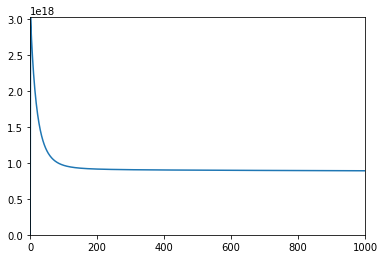

In [11]:
plt.plot(range(len(cost_history)),cost_history)
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

MSE: 1011621054937529728.0000


C:\Users\Qiuyan\Miniconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


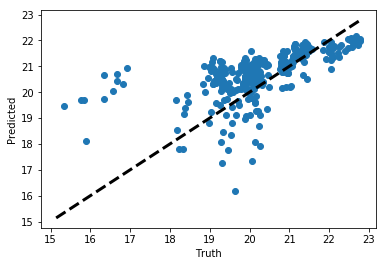

In [19]:
pred_y = sess.run(y_, feed_dict={X: test_x})
mse = tf.reduce_mean(tf.square(pred_y - test_y))
print("MSE: %.4f" % sess.run(mse)) 

fig, ax = plt.subplots()
ax.scatter(np.log(test_y), np.log(pred_y))
ax.plot([np.log(test_y.min()), np.log(test_y.max())], [np.log(test_y.min()), np.log(test_y.max())], 'k--', lw=3)
ax.set_xlabel('Truth')
ax.set_ylabel('Predicted')
plt.show()

In [13]:
#sess.close()

In [14]:
r2_score(test_y,pred_y)

0.5526546105313759

In [16]:
with h5py.File('model.hdf5', 'w') as f:
    for var in tf.trainable_variables():
        key = var.name.replace('/', ' ')
        value = sess.run(var)
        f.create_dataset(key, data=value)